In [1]:
import sys
import os
import math
import logging
import galsim
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect
import argparse
from IPython.display import clear_output
from numpy.random import random_sample
import matplotlib
from astropy.io import fits
from matplotlib.colors import LogNorm
import pandas as pd
import scipy
import seaborn as sns

In [2]:
def find_kurtosis(arr):
    total_counts = np.sum(arr)
    
    h,w = np.shape(arr)

    x = range(w)
    y = range(h)
    
    yp = np.sum(arr,axis=1)
    xp = np.sum(arr,axis=0)

    #centroid
    cx = np.sum(x*xp)/np.sum(xp)
    cy = np.sum(y*yp)/np.sum(yp)
    
    #second moments
    Sxx = np.sum((x-cx)**2*xp)/total_counts
    Syy = np.sum((y-cy)**2*yp)/total_counts
    
    sum_Sxy = 0
    global sum_Sxy
    for pos,counts in np.ndenumerate(arr):
        
        sum_Sxy += (pos[0]-cx)*(pos[1]-cy)*counts
    
    Sxy = sum_Sxy/total_counts

    #vectorization
    cov = np.zeros(shape=(2,2))
    cov[0][0], cov[0][1], cov[1][0], cov[1][1] = Sxx,Sxy,Sxy,Syy
    
    cen = np.array([[cx],[cy]])
    
    #calculate kurtosis
    sum_kurt = 0
    global sum_kurt
    
    inv_cov = np.linalg.inv(cov)
    
    for pos,counts in np.ndenumerate(arr):

        displacement = (np.array(pos).T-cen)[0]
        
        sum_kurt+=np.matmul(displacement,np.matmul(inv_cov,displacement))**2*counts
    

    kurt = sum_kurt/total_counts
    
    return kurt
    
    


<ipython-input-2-143c4560b967>:21: SyntaxWarning: name 'sum_Sxy' is assigned to before global declaration
  global sum_Sxy
<ipython-input-2-143c4560b967>:36: SyntaxWarning: name 'sum_kurt' is assigned to before global declaration
  global sum_kurt


In [2]:
def find_kurtosis_2(image):
    res = galsim.hsm.FindAdaptiveMom(image)
    return res.moments_rho4

In [6]:
def find_moment(image):
    res = galsim.hsm.FindAdaptiveMom(image)
    return res.moments_sigma, res.observed_shape, res.moments_rho4

In [4]:
def statistical_propertis(x):
    mean = np.average(x)
    std = np.std(x)
    skewness = scipy.stats.skew(x)
    kurtosis = scipy.stats.kurtosis(x,fisher=False)
    return mean, std, skewness, kurtosis

In [7]:
star_flux = 1e5
kolmogorov_hlr = 0.6
optical_fwhm = 0.02
psf1 = galsim.Kolmogorov(flux = star_flux, half_light_radius=kolmogorov_hlr)
psf2 = galsim.OpticalPSF(optical_fwhm)
psf = galsim.Convolve([psf1,psf2])

clean_image = psf.drawImage(scale = 0.2)
true_kurtosis = find_kurtosis_2(clean_image)
print true_kurtosis

2.09350590884


In [4]:
def testSNR(psf, snr, n = 1000):
    
    kurtosis_list = []
    
    
    
    for i in range(n):
        pn = galsim.GaussianNoise()
        clean_image = psf.drawImage(scale = 0.2)
        clean_image.addNoiseSNR(pn, snr, preserve_flux=True)
        try:
            this_kurtosis = find_kurtosis_2(clean_image)
            kurtosis_list.append(this_kurtosis)
        except:
            print ("gotcha fam")
        #print this_kurtosis
        
        if ((i+1)*100)%n==0:
            clear_output() 
            print ("Finished "+str(float((i+1))/n*100)+"% ( snr = " +str(snr)+" )")
    return np.array(kurtosis_list)

In [ ]:
def testSNR2(psf, snr, n = 1000):
    
    
    
    kurtosis_list = []
    
    
    
    for i in range(n):
        pn = galsim.GaussianNoise()
        clean_image = psf.drawImage(scale = 0.2)
        clean_image.addNoiseSNR(pn, snr, preserve_flux=True)
        try:
            this_kurtosis = find_kurtosis_2(clean_image)
            kurtosis_list.append(this_kurtosis)
        except:
            print ("gotcha fam")
        #print this_kurtosis
        
        if ((i+1)*100)%n==0:
            clear_output() 
            print ("Finished "+str(float((i+1))/n*100)+"% ( snr = " +str(snr)+" )")
    return np.array(kurtosis_list)

In [5]:
sns.distplot(kurtosis1k-true_kurtosis ,  bins=100, hist = False,label='SNR = 1000')


plt.xlim([-0.1,0.1])
plt.xlabel("Kurtosis uncertainty of PSF")
plt.ylabel("Probability")
plt.title("Distribution of error in kurtosis for multiple SNR (Gaussian Noise)")
plt.show()


NameError: name 'kurtosis1k' is not defined

In [321]:
kurtosis1k = testSNR(psf,1000.)
kurtosis2k = testSNR(psf,2000.)
kurtosis4k = testSNR(psf,4000.)
kurtosis8k = testSNR(psf,8000.)
kurtosis16k = testSNR(psf,16000.)

Finished 100.0% ( snr = 16000.0 )


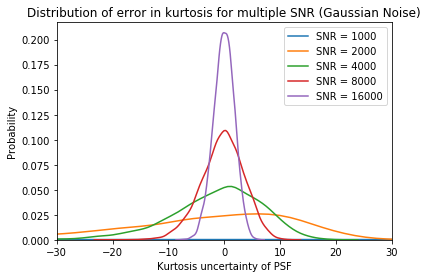

Mean                Std                 Skewness            Kurtosis            
(-876.7597029682543, 24817.923063255355, -31.42676636877557, 991.5914702049863) SNR = 1,000
(30.984698490359097, 21.1525689196411, -1.820040038913844, 8.963882264062025) SNR = 2,000
(35.798897703230494, 8.230138247224216, -0.7372847220693917, 4.19631365172701) SNR = 4,000
(36.867111820405114, 3.83420124409096, -0.32339927365204196, 3.28438509152669) SNR = 8,000
(37.14113473122158, 1.8780180510536437, -0.1599431314079905, 2.9933206766217397) SNR = 16,000


In [222]:
sns.distplot(kurtosis1k-true_kurtosis ,  bins=100, hist = False,label='SNR = 1000')
sns.distplot(kurtosis2k-true_kurtosis,  bins=100, hist = False,label='SNR = 2000')
sns.distplot(kurtosis4k-true_kurtosis,  bins=100, hist = False,label='SNR = 4000')
sns.distplot(kurtosis8k-true_kurtosis,  bins=100, hist = False,label='SNR = 8000')
sns.distplot(kurtosis16k-true_kurtosis,  bins=100, hist = False,label='SNR = 16000')

plt.xlim([-30,30])
plt.xlabel("Kurtosis uncertainty of PSF")
plt.ylabel("Probability")
plt.title("Distribution of error in kurtosis for multiple SNR (Gaussian Noise)")
plt.show()

#Statistical properties
print "".join(word.ljust(20) for word in ["Mean","Std","Skewness","Kurtosis"])
print statistical_propertis(kurtosis1k), "SNR = 1,000"
print statistical_propertis(kurtosis2k), "SNR = 2,000"
print statistical_propertis(kurtosis4k), "SNR = 4,000"
print statistical_propertis(kurtosis8k), "SNR = 8,000"
print statistical_propertis(kurtosis16k), "SNR = 16,000"

(-876.7597029682543, 24817.923063255355, -31.42676636877557, 991.5914702049863)
(30.984698490359097, 21.1525689196411, -1.820040038913844, 8.963882264062025)
(35.798897703230494, 8.230138247224216, -0.7372847220693917, 4.19631365172701)
(36.867111820405114, 3.83420124409096, -0.32339927365204196, 3.28438509152669)
(37.14113473122158, 1.8780180510536437, -0.1599431314079905, 2.9933206766217397)


In [184]:
kurtosis1kccd = testSNR(psf,1000.)
kurtosis2kccd = testSNR(psf,2000.)
kurtosis4kccd = testSNR(psf,4000.)
kurtosis8kccd = testSNR(psf,8000.)
kurtosis16kccd = testSNR(psf,16000.)

Finished 100.0% ( snr = 16000.0 )


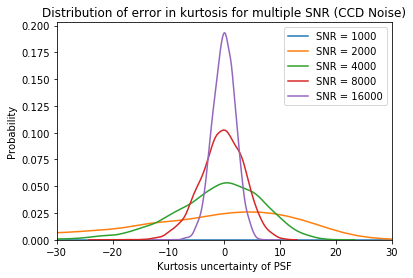

Mean                Std                 Skewness            Kurtosis            
(-1738.813325827267, 102657.15745211273, -78.28033907473103, 6576.962469613799) SNR = 1,000
(30.62414961488948, 21.833988646009352, -2.0030946915213064, 10.857975313385792) SNR = 2,000
(35.92458539955132, 8.117294992671125, -0.6723970882650216, 3.7277102656179144) SNR = 4,000
(36.81332144837215, 3.884696112952992, -0.2805025145140134, 3.1843426024392794) SNR = 8,000
(37.14650149905863, 2.0623809072438064, -0.13823757140699125, 3.0998851190187353) SNR = 16,000


In [219]:
sns.distplot(kurtosis1kccd-true_kurtosis ,  bins=100, hist = False,label='SNR = 1000')
sns.distplot(kurtosis2kccd-true_kurtosis,  bins=100, hist = False,label='SNR = 2000')
sns.distplot(kurtosis4kccd-true_kurtosis,  bins=100, hist = False,label='SNR = 4000')
sns.distplot(kurtosis8kccd-true_kurtosis,  bins=100, hist = False,label='SNR = 8000')
sns.distplot(kurtosis16kccd-true_kurtosis,  bins=100, hist = False,label='SNR = 16000')

plt.xlim([-30,30])
plt.xlabel("Kurtosis uncertainty of PSF")
plt.ylabel("Probability")
plt.title("Distribution of error in kurtosis for multiple SNR (CCD Noise)")
plt.show()

#Statistical properties
print "".join(word.ljust(20) for word in ["Mean","Std","Skewness","Kurtosis"])
print statistical_propertis(kurtosis1kccd), "SNR = 1,000"
print statistical_propertis(kurtosis2kccd), "SNR = 2,000"
print statistical_propertis(kurtosis4kccd), "SNR = 4,000"
print statistical_propertis(kurtosis8kccd), "SNR = 8,000"
print statistical_propertis(kurtosis16kccd), "SNR = 16,000"

Mean                Std                 Skewness            Kurtosis            
(-1738.813325827267, 102657.15745211273, -78.28033907473103, 6576.962469613799) SNR = 1,000
(30.62414961488948, 21.833988646009352, -2.0030946915213064, 10.857975313385792) SNR = 2,000
(35.92458539955132, 8.117294992671125, -0.6723970882650216, 3.7277102656179144) SNR = 4,000
(36.81332144837215, 3.884696112952992, -0.2805025145140134, 3.1843426024392794) SNR = 8,000
(37.14650149905863, 2.0623809072438064, -0.13823757140699125, 3.0998851190187353) SNR = 16,000


In [208]:
min(kurtosis16kccd)

25.328589450222548

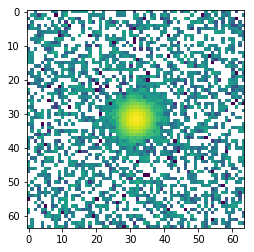

In [248]:
pn = galsim.PoissonNoise()
clean_image = psf.drawImage(scale = 0.2)
clean_image.addNoiseSNR(pn, 400, preserve_flux=True)

plt.imshow(clean_image.array,norm = LogNorm())

(-200, 200)

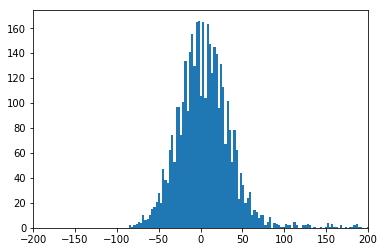

In [249]:
plt.hist(clean_image.array.ravel(),1000)
plt.xlim([-200,200])


In [250]:
print np.sum(clean_image.array)

103123.0


In [320]:
gal_profile = galsim.Gaussian(sigma = 1.)
for i in range(50):
    image = gal_profile.drawImage(scale = 0.1)
    pn = galsim.GaussianNoise()
    image.addNoiseSNR(pn, 40., preserve_flux=True)

    results = galsim.hsm.FindAdaptiveMom(image)
    rho4 = results.moments_rho4
    print rho4

1.97777449534
1.94855573115
2.01344608205
1.991928495
1.96815558468
1.99199907496
2.01498667193
2.0450847086
1.99622331634
1.9654558984
1.96421879505
2.0317469516
2.06983156824
1.99830568415
2.00010641959
1.95125256752
1.99875789585
1.91567198636
1.94828038608
1.94165242303
2.03648515127


GalSimHSMError: Error: too many iterations in adaptive moments


In [8]:
kurtosis50 = testSNR(psf,50.)
kurtosis100 = testSNR(psf,100.)
kurtosis200 = testSNR(psf,200.)
kurtosis400 = testSNR(psf,400.)
kurtosis800 = testSNR(psf,800.)

Finished 100.0% ( snr = 800.0 )


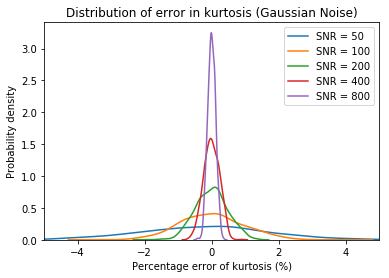

Mean                   Std                    Skewness               Kurtosis               
(-0.005006010763521006, 0.03981109166153306, -0.11585730464344964, 3.158107820164169) SNR = 50
(2.7311972524074245e-05, 0.020112552839606206, 0.11517297597939963, 3.209211266619607) SNR = 100
(-9.644137141086251e-05, 0.010016146308069294, -0.06796782271556659, 3.0769155969682838) SNR = 200
(-8.123957754989864e-06, 0.0049082875569323855, -0.051269574323327086, 2.7460129925016927) SNR = 400
(5.325600780918816e-05, 0.0024445351489125406, -0.051545289126988844, 2.896570957329194) SNR = 800


In [10]:
sns.distplot((kurtosis50-true_kurtosis)/true_kurtosis*100 ,  bins=100, hist = False,label='SNR = 50')
sns.distplot((kurtosis100-true_kurtosis)/true_kurtosis*100,  bins=100, hist = False,label='SNR = 100')
sns.distplot((kurtosis200-true_kurtosis)/true_kurtosis*100,  bins=100, hist = False,label='SNR = 200')
sns.distplot((kurtosis400-true_kurtosis)/true_kurtosis*100,  bins=100, hist = False,label='SNR = 400')
sns.distplot((kurtosis800-true_kurtosis)/true_kurtosis*100,  bins=100, hist = False,label='SNR = 800')

plt.xlim([-5,5])
plt.xlabel("Percentage error of kurtosis (%)")
plt.ylabel("Probability density")
plt.title("Distribution of error in kurtosis (Gaussian Noise)")
plt.show()

#Statistical properties
print "".join(word.ljust(23) for word in ["Mean","Std","Skewness","Kurtosis"])
print statistical_propertis(kurtosis50-true_kurtosis), "SNR = 50"
print statistical_propertis(kurtosis100-true_kurtosis), "SNR = 100"
print statistical_propertis(kurtosis200-true_kurtosis), "SNR = 200"
print statistical_propertis(kurtosis400-true_kurtosis), "SNR = 400"
print statistical_propertis(kurtosis800-true_kurtosis), "SNR = 800"